In [4]:
import pandas as pd

In [5]:

from statistics import mode
def find_clusters_with_size(grid, cluster_size, lsm_average, lsm_threshold):
    ''' Function to find clusters of a certain size in a grid
    :param grid: 2D numpy array
    :param cluster_size: int
    :param lsm_average: 2D numpy array from data array, where average is the mean fraction of the lsm values in the convolution window around cell of 9x9
    :param lsm_threshold: float
    '''
    rows, cols = len(grid), len(grid[0])
    visited = [[False] * cols for _ in range(rows)]
    new_grid = np.zeros((rows, cols), dtype=int)
    discarded_grid = np.zeros((rows, cols), dtype=int)  # Create a "discarded" grid


    def dfs(row, col):
        stack = [(row, col)]
        island_coords = []  # List to store island coordinates
        lsm_average_values = []  # List to store lsm_average values
        size = 0
        while stack:
            r, c = stack.pop()
            if 0 <= r < rows and 0 <= c < cols and grid[r][c] == 1 and not visited[r][c]:
                visited[r][c] = True
                island_coords.append([r, c])  # Add current coordinate to island_coords
                lsm_average_values.append(lsm_average[r][c])  # Add current lsm_average value to lsm_average_values
                size += 1
                for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]:  # Add diagonal directions
                    stack.append((r + dr, c + dc))
        return size, island_coords, lsm_average_values


    for i in tqdm(range(rows)):
        for j in range(cols):
            if grid[i][j] == 1 and not visited[i][j]:
                island_size, island_coords, lsm_average_values = dfs(i, j)
                lsm_average_mode = mode(lsm_average_values)
                if island_size >= cluster_size:  # Only consider islands of cluster_size and up
                    for r, c in island_coords:
                        new_grid[r][c] = 1
                else:  # Add islands smaller than cluster_size to the "discarded" grid
                    if lsm_average_mode > lsm_threshold:
                        for r, c in island_coords:
                            new_grid[r][c] = 1
                    else:
                        for r, c in island_coords:
                            discarded_grid[r][c] = 1

    return new_grid, discarded_grid





We remove small fjords, "clusters of neighbouring cells" and then for the smaller one we check whether it is not surrounded by at least 75% land, to check if there are no missing branches

In [9]:
from open_preprocess_racmo import *

MaskFjord = open_mask_1k()

# Find how much percent of the surrounding cells, in a grid by 9x9, are land
# Define a kernel that represents the surrounding cells
# The center value is 0 because we don't want to include the center cell in the average
from scipy.signal import convolve2d
kernel = np.array([  [0, 0, 0, 1, 1, 1, 0, 0, 0],
                     [0, 0, 1, 1, 1, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 1, 1, 1, 0],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [0, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 1, 1, 1, 1, 1, 0, 0],
                     [0, 0, 0, 1, 1, 1, 0, 0, 0] ] )

# Perform a convolution operation on the "LSM" grid with the kernel
convolved = convolve2d(MaskFjord['LSM'].values, kernel, mode='same')
average = convolved/np.sum(kernel)
MaskFjord['LSM_average'] = xr.DataArray(average, coords=MaskFjord['LSM'].coords, dims=MaskFjord['LSM'].dims)


# find fjords with a minimum cluster size of min_cluster_size or smaller clusters with mode of lsm_average > ls_threshold between 0 and 1
min_cluster_size = 30
# threshold is chosen such that we 'exclude' bays with a lot of surrounding land but include parts of fjords that are surrounded by land
lsm_threshold = 0.75
grid = MaskFjord['fjords'].values
new_grid,discarded  = find_clusters_with_size(grid, min_cluster_size,MaskFjord['LSM_average'].values, lsm_threshold=lsm_threshold)

MaskFjord['no_small_fjords'] = xr.DataArray(new_grid, coords=MaskFjord['fjords'].coords, dims=MaskFjord['fjords'].dims)
MaskFjord['small_clusters'] = xr.DataArray(discarded, coords=MaskFjord['fjords'].coords, dims=MaskFjord['fjords'].dims)


MaskFjord = MaskFjord.rename({'fjords':'fjords_all','no_small_fjords':'fjords'})
MaskFjord.to_netcdf(pathFjordMask)


100%|██████████| 2700/2700 [00:14<00:00, 188.31it/s]


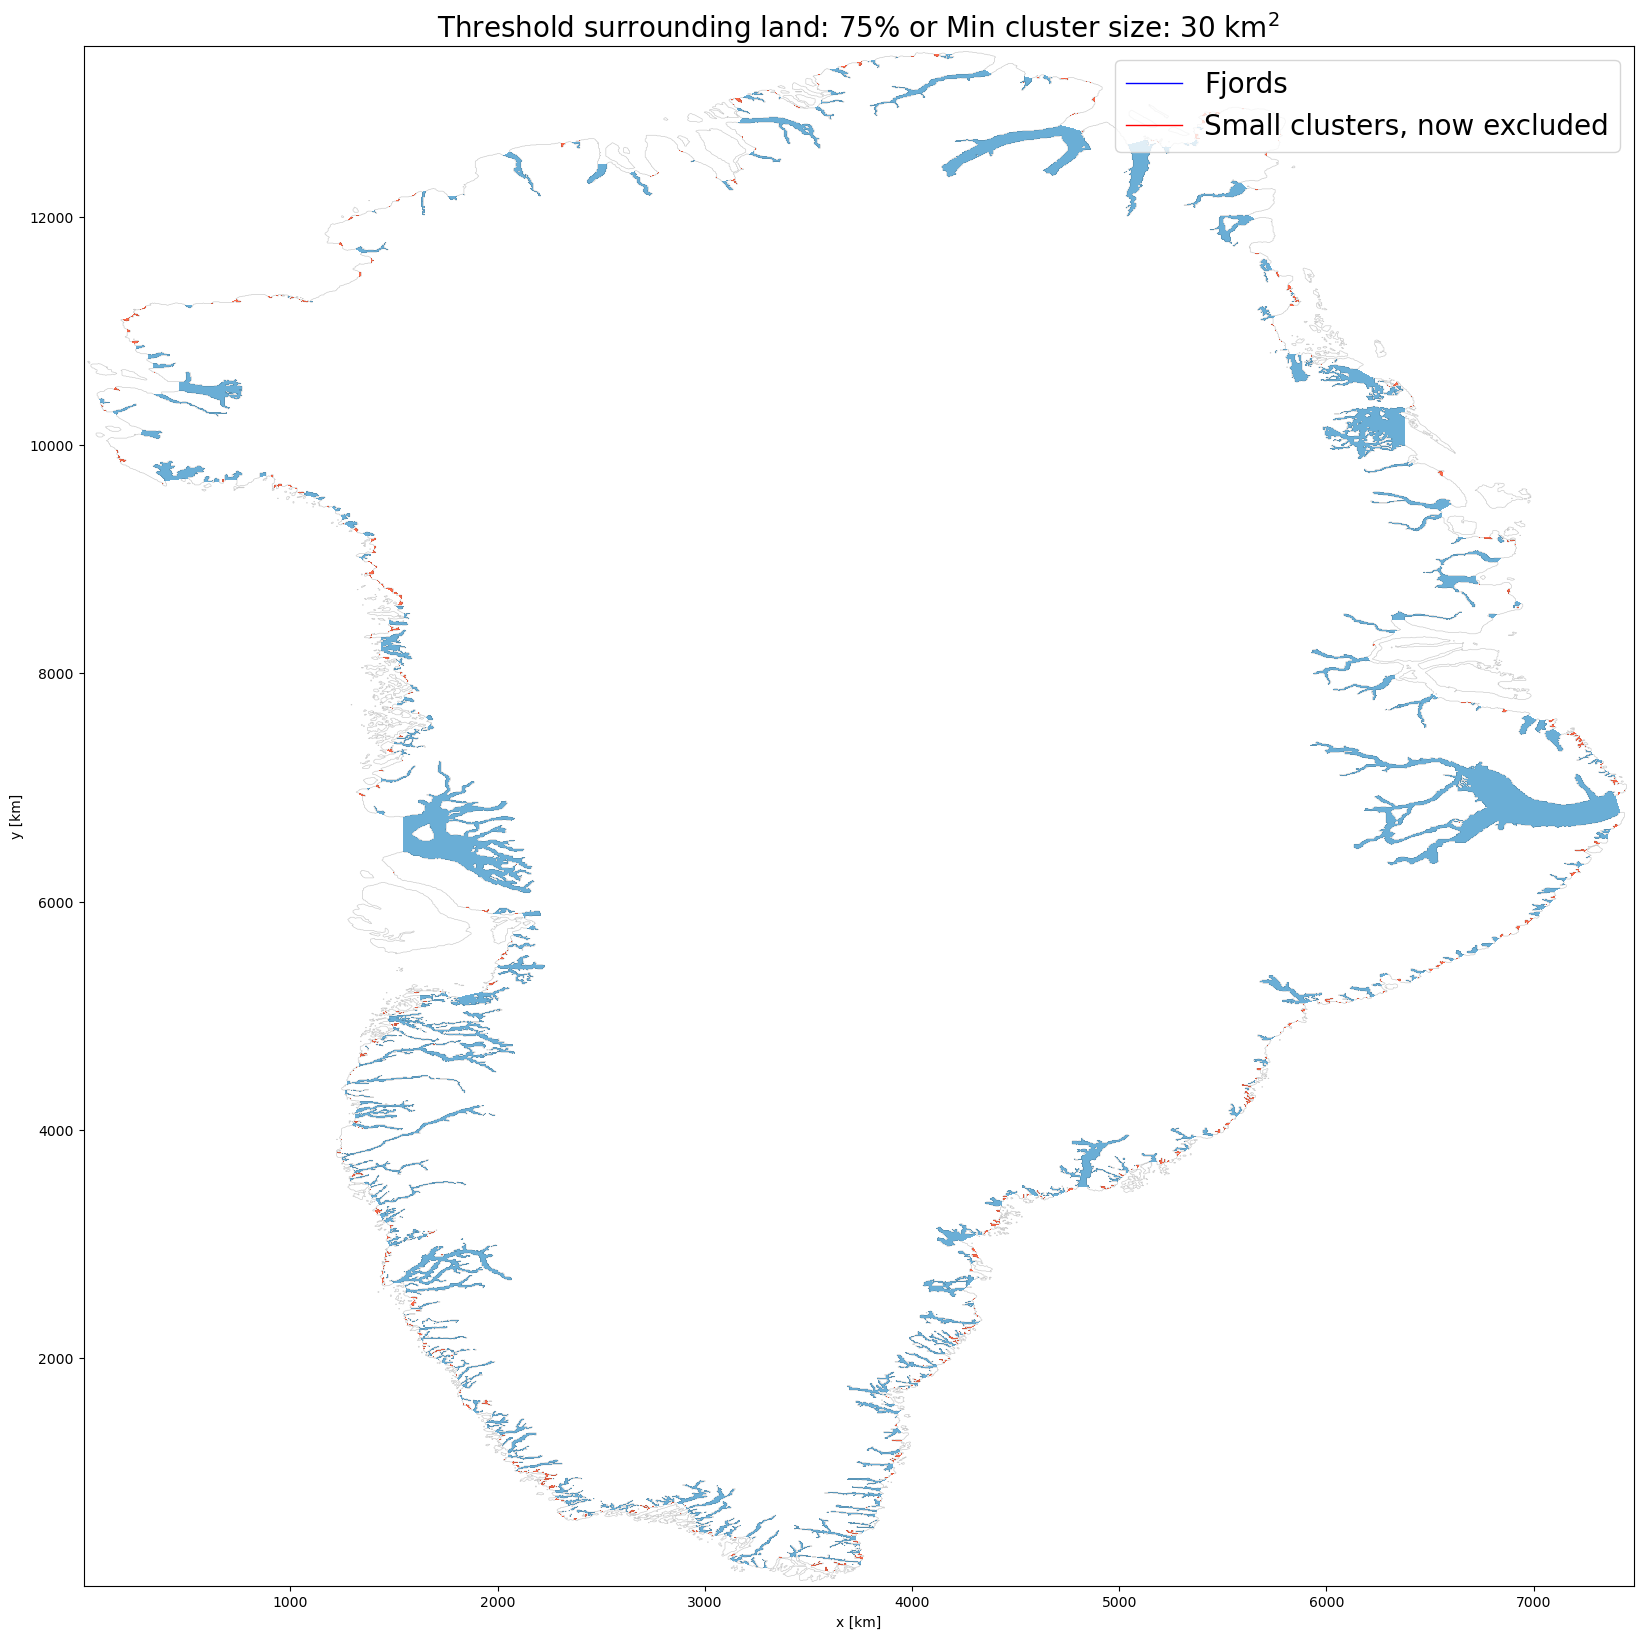

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(20,20))
MaskFjord['LSM'].plot.contour(ax=ax, colors='black', levels=[0.5], linewidths=0.5, alpha=0.2)

MaskFjord['no_small_fjords'].where(MaskFjord['no_small_fjords']==1).plot(ax=ax, cmap='Blues', add_colorbar=False)
MaskFjord['small_clusters'].where(MaskFjord['small_clusters']==1).plot(ax=ax, cmap='Reds', add_colorbar=False)

# add legend with handles and labels
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=1, label='Fjords'),
                Line2D([0], [0], color='red', lw=1, label='Small clusters, now excluded')]
ax.legend(handles=custom_lines, loc='upper right', fontsize=20)
# add title with threshold and min_cluster_size
ax.set_title(f"Threshold surrounding land: {lsm_threshold*100:.0f}% or Min cluster size: {min_cluster_size} "+r"km$^2$", fontsize=20)
# save in results figures methods
fig.savefig("../../results/figures/method/no_small_fjords_simple.png", dpi=300)

/Users/annek/opt/anaconda3/envs/phdIIfresh/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2013: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)


Text(0.5, 1.0, 'No small fjords (yellow), minimum size 30 km2')

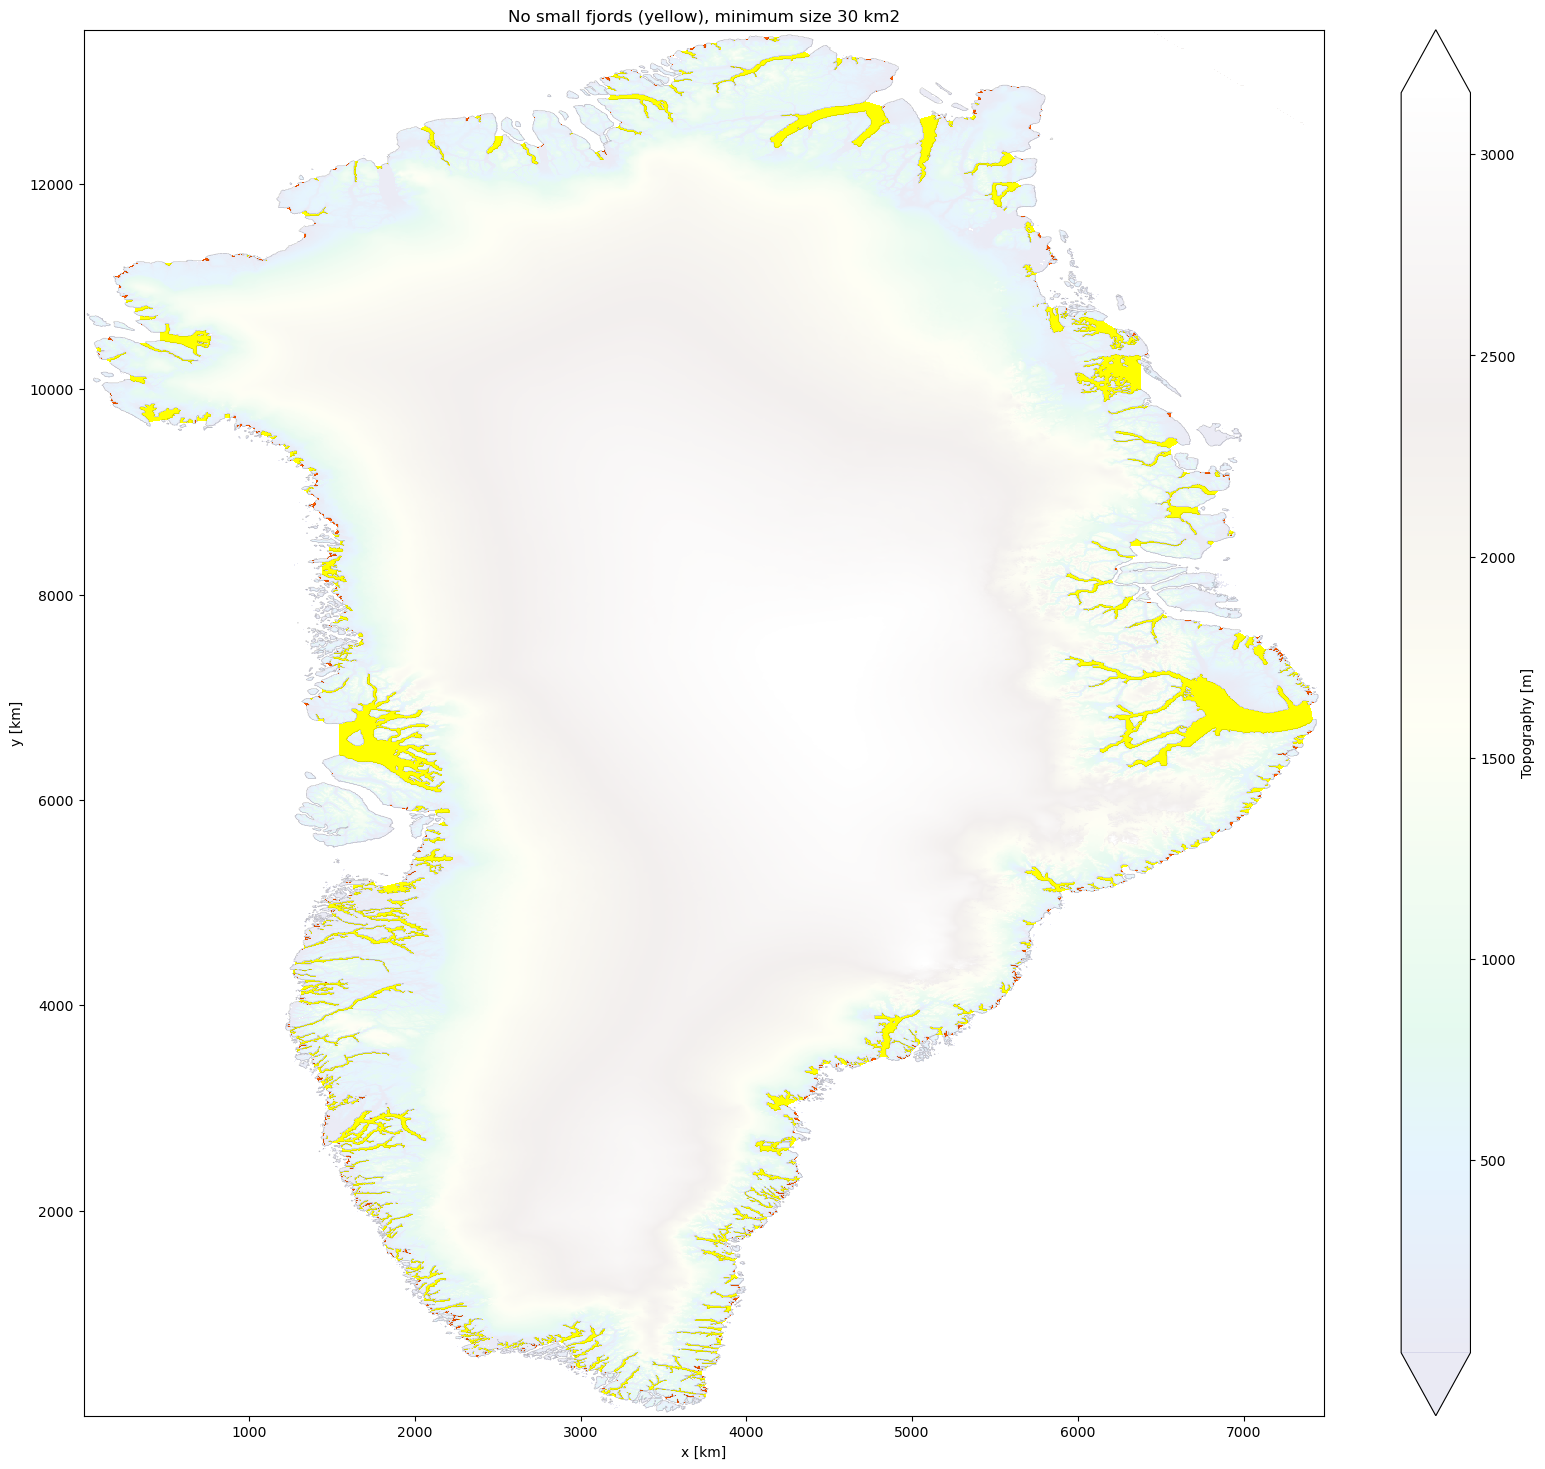

In [11]:
from matplotlib.colors import ListedColormap
cmap_yellow = ListedColormap(['yellow'])
cmap_pink = ListedColormap(['pink'])

fig, ax = plt.subplots(1,1, figsize=(20,18))
topography_plot=MaskFjord['Topography'].where(MaskFjord['Topography']>0).plot.imshow(ax=ax, cmap='terrain', robust=True, alpha=0.1)
lsm_plot = MaskFjord['LSM'].plot.contour(ax=ax, colors='black', linewidths=0.1, label='Land-sea boundary', alpha=0.2)
fjords_plot = MaskFjord['fjords_all'].where(MaskFjord['fjords_all'] == 1).plot.imshow(ax=ax, label='Fjords',  add_colorbar=False, cmap= 'hot')
fjords_plot = MaskFjord['fjords'].where(MaskFjord['fjords'] == 1).plot.imshow(ax=ax, label='Fjords > 20 km2', add_colorbar=False, cmap=cmap_yellow)


ax.set_title(f'No small fjords (yellow), minimum size {min_cluster_size} km2')

# Save the figure
# fig.savefig("../../results/figures/method/no_small_fjords.png", dpi=300) 